# importing lib

In [26]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import nltk

In [27]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\4t4\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\4t4\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\4t4\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# reading the data

In [ ]:
sampled_data = pd.read_csv('tweet_data.csv')
sampled_data =sampled_data[['text','target']]
print(f"Data shape: {sampled_data.shape}")


Data shape: (240000, 2)


In [29]:
sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    240000 non-null  object
 1   target  240000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


### removing duplicates

In [30]:
sampled_data.duplicated().sum()
sampled_data.drop_duplicates(inplace=True)

### checking the balance 

In [31]:
sampled_data.value_counts('target')

target
1    119606
0    119343
Name: count, dtype: int64

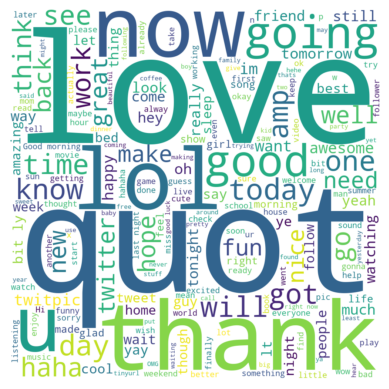

In [32]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
pos = sampled_data[sampled_data['target'] == 1]
all_text = ' '.join(pos['text'])
wordcloud = WordCloud(width = 1000, height = 1000, background_color = 'white').generate(all_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

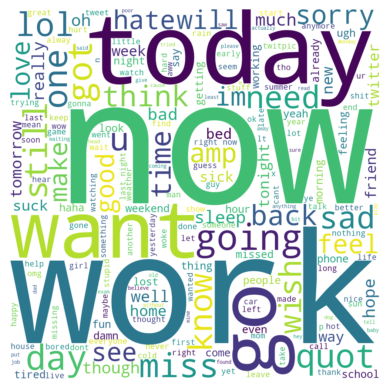

In [33]:
neg = sampled_data[sampled_data['target'] == 0]
all_text = ' '.join(neg['text'])
wordcloud = WordCloud(width = 1000, height = 1000, background_color = 'white').generate(all_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Text Cleaning

In [ ]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    custom_stopwords = {'today', 'work', 'now', 'lol', 'quot', 'thank'}

    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    #text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    tokens = word_tokenize(text)
    stopword_list = stopwords.words('english')
    stopword_list.remove('not')
    stopword_list.remove('no')
    stopword_list.remove('nor')
    stopword_list.extend(custom_stopwords)

    tokens = [word for word in tokens if word not in stopword_list]
    tokens = [word for word in tokens if len(word) > 1]
    
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    text = ' '.join(tokens)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

sampled_data['cleaned_text'] = sampled_data['text'].apply(clean_text)

this shows that after cleaning, an empty tweets appeard.
we will remove them 

In [35]:
empty_cleaned = (sampled_data['cleaned_text'] == '').sum()
print(f"\nNumber of empty strings after cleaning: {empty_cleaned}")


Number of empty strings after cleaning: 1287


In [36]:
sampled_data = sampled_data[sampled_data['cleaned_text'] != '']


# Splitting the data

In [37]:
X = sampled_data['cleaned_text']
y = sampled_data['target']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [39]:
print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Training set size: 190129
Test set size: 47533


# model Building

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np


text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1, 3),      
        max_features = 45000,         
        min_df=2,                
        max_df=0.95           
    )),
    ('model', LogisticRegression(
        C=10.0,                     
        max_iter=3000,             
        random_state=42
    ))
])

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

print(f"Performing {num_folds}-fold cross-validation...")
cv_scores = cross_val_score(text_clf, X_train, y_train, cv=kf, scoring='accuracy')

print("Training final model on full training set...")
text_clf.fit(X_train, y_train)

y_test_pred = text_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard deviation: {np.std(cv_scores):.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))
#0.7799

Performing 5-fold cross-validation...
Training final model on full training set...

Cross-validation scores: [0.77165624 0.77241887 0.77013096 0.77128807 0.77335963]
Mean CV accuracy: 0.7718
Standard deviation: 0.0011
Test accuracy: 0.7712

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77     23770
           1       0.77      0.78      0.77     23763

    accuracy                           0.77     47533
   macro avg       0.77      0.77      0.77     47533
weighted avg       0.77      0.77      0.77     47533



## Building Predictive Model

In [41]:
#negative
tweet = "I've been using this service for over a year now," \
" and while there were some good moments, the recent changes " \
"have been extremely frustrating. The app crashes constantly," \
" customer support is unresponsive, and honestly, it's becoming more trouble than it's worth." \
" I really hope they fix these issues soon because I'm losing patience day by day."


tweet = clean_text(tweet)
prediction = text_clf.predict([tweet])

prediction_proba = text_clf.predict_proba([tweet])

label = 'Positive' if prediction[0] == 1 else 'Negative'
confidence = np.max(prediction_proba)

print(f"Tweet: {tweet}")
print(f"Predicted Label: {label}")
print(f"Confidence: {confidence:.4f}")
#0.8528


Tweet: 've using service year good moment recent change extremely frustrating app crash constantly customer support unresponsive honestly 's becoming trouble 's worth really hope fix issue soon 'm losing patience day day
Predicted Label: Negative
Confidence: 0.9623


In [42]:
#positive
tweet = "I've been using this product for a few months now, and while I was initially skeptical about its effectiveness," \
" I must admit that it's really grown on me. Sure, there have been a couple of hiccups along the way," \
" like a few delayed updates, but overall, it's been a pretty solid experience. " \
"The customer service team has been very helpful when I've reached out, " \
"and I can't wait to see how they improve it in the future. Definitely glad I gave it a chance."

tweet = clean_text(tweet)
prediction = text_clf.predict([tweet])

prediction_proba = text_clf.predict_proba([tweet])

label = 'Positive' if prediction[0] == 1 else 'Negative'
confidence = np.max(prediction_proba)

print(f"Tweet: {tweet}")
print(f"Predicted Label: {label}")
print(f"Confidence: {confidence:.4f}")
#0.8508


Tweet: 've using product month initially skeptical effectiveness must admit 's really grown sure couple hiccup along way like delayed update overall 's pretty solid experience customer service team helpful 've reached ca n't wait see improve future definitely glad gave chance
Predicted Label: Positive
Confidence: 0.9471


In [43]:
#negative
tweet = "Well, this new feature update is definitely something."\
     " It’s not like it’s completely broken,but, you know, it’s not exactly the amazing improvement we were promised." \
    "Sure, it does work — sometimes. And yes, the design looks nice, but it’s honestly just too much to handle all at once."\
    " I guess the team tried... sort of. Maybe they’ll get it right next time. But hey, at least they tried, right?"

tweet = clean_text(tweet)
prediction = text_clf.predict([tweet])

prediction_proba = text_clf.predict_proba([tweet])

label = 'Positive' if prediction[0] == 1 else 'Negative'
confidence = np.max(prediction_proba)

print(f"Tweet: {tweet}")
print(f"Predicted Label: {label}")
print(f"Confidence: {confidence:.4f}")
#0.6266

Tweet: well new feature update definitely something not like completely broken know not exactly amazing improvement promised.sure sometimes yes design look nice honestly much handle guess team tried ... sort maybe get right next time hey least tried right
Predicted Label: Positive
Confidence: 0.5137


In [ ]:
#positive
tweet = "I absolutely love the new update! It makes everything so much easier to use. Well done team!"

tweet = clean_text(tweet)
prediction = text_clf.predict([tweet])

prediction_proba = text_clf.predict_proba([tweet])

label = 'Positive' if prediction[0] == 1 else 'Negative'
confidence = np.max(prediction_proba)

print(f"Tweet: {tweet}")
print(f"Predicted Label: {label}")
print(f"Confidence: {confidence:.4f}")
#0.9085

Tweet: absolutely love new update make everything much easier use well done team
Predicted Label: Positive
Confidence: 0.9465


In [45]:
#negative
tweet = "The new app update is great for some things, " \
"but it’s still missing a lot of features that I was really hoping for. " \
"I love the new design, but it’s just not enough to make up for the bugs that keep crashing the app."

tweet = clean_text(tweet)
prediction = text_clf.predict([tweet])

prediction_proba = text_clf.predict_proba([tweet])

label = 'Positive' if prediction[0] == 1 else 'Negative'
confidence = np.max(prediction_proba)

print(f"Tweet: {tweet}")
print(f"Predicted Label: {label}")
print(f"Confidence: {confidence:.4f}")
#0.7017

Tweet: new app update great thing still missing lot feature really hoping love new design not enough make bug keep crashing app
Predicted Label: Negative
Confidence: 0.9283
